In [171]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

## Business Understanding

We will analyze the Seattle Property Listings to answer this 3 questions:
1. How does listing availability and price change over the course of the year in Seattle?
2. Which neighbourhood has the most listings?
3. Which features affect the Pricing of a property the most?



## Data Gathering

Data was gathered from Kaggle [here](https://www.kaggle.com/airbnb/seattle). The files are saved into the current directory under ./data/seattle/ subdirectory.

## Data Assessment and Data Cleaning

In [172]:
listings_df = pd.read_csv("seattle/listings.csv")

In [173]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [174]:
calender_df=pd.read_csv("seattle/calendar.csv")

In [175]:
calender_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [176]:
reviews_df = pd.read_csv("seattle/reviews.csv", dtype=str)

In [177]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [178]:
# Convert date to timestamp, available to 0/1 boolean
calender_df["date"] = calender_df["date"].map(lambda x: pd.Timestamp(x))
calender_df["available"] = calender_df["available"].map(lambda x: 1 if x=="t" else 0)

# Remove comma and $ sign from price strings, then convert to float
calender_df.loc[~calender_df["price"].isna(), "price"] = \
  calender_df.loc[~calender_df["price"].isna(), "price"].map(lambda x: x.replace("$", "").replace(",", ""))
calender_df["price"] = calender_df["price"].astype("float64")

In [179]:
calender_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,NaN
3,241032,2016-01-07,0,NaN
4,241032,2016-01-08,0,NaN


In [180]:
# Average rating of the apps 
listings_df.shape

(3818, 92)

In [181]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [182]:
one_hot_encoded_values = ["zipcode", "neighbourhood_cleansed", "last_review", "first_review", "street", "smart_location"]

### Handling missing Data
The following columns are dropped from data because of the following reasons:

In [183]:
drop_columns = [
    "experiences_offered", # All null values
    "city", # SEATTLE
    "state", # WA
    "calendar_last_scraped", # '2016-01-04'
    "jurisdiction_names", # WASHINGTON
    "license", # All null values
    "market", # SEATTLE
    "has_availability", # All True
    "latitude",
    "longitude", # This values can be clustered together to form localites but we are ignorinng it for now
    "requires_license", # All false
    "country_code", # US
    "country" # US
    
    
]

In [184]:
def map_amenities(l):
    return [a.strip("\"'' ") for a in l.strip("{}").split(",")]

In [185]:
listings_df["host_verifications"].head()

0                 ['email', 'phone', 'reviews', 'kba']
1    ['email', 'phone', 'facebook', 'linkedin', 're...
2     ['email', 'phone', 'google', 'reviews', 'jumio']
3    ['email', 'phone', 'facebook', 'reviews', 'jum...
4     ['email', 'phone', 'facebook', 'reviews', 'kba']
Name: host_verifications, dtype: object

### Handle List Data 
Amenities and host verification are in a list in the data. We need to transform it to convert it to a usable format by encoding the values.

In [186]:
#Handle Amenities and host_verifications

In [187]:
temp1_ = listings_df.drop('amenities', 1).join(
    pd.get_dummies(
        pd.DataFrame(listings_df.amenities.apply(map_amenities).tolist()).stack()
    ).astype(int).sum(level=0)
)


In [188]:
def map_host_verifications(l):
    return [a.strip("\"'' ") for a in l.strip("[]").split(",")]

In [189]:

listings_trans = temp1_.drop('host_verifications', 1).join(
    pd.get_dummies(
        pd.DataFrame(temp1_.host_verifications.apply(map_host_verifications).tolist()).stack()
    ).astype(int).sum(level=0), lsuffix="hv_"
).drop("hv_",1).drop("None",1)

## Data Analysis, Modeling and Visualization

### How does availability and price change over the course of the year

Text(0.5, 1.0, 'Seattle availability (%) by date')

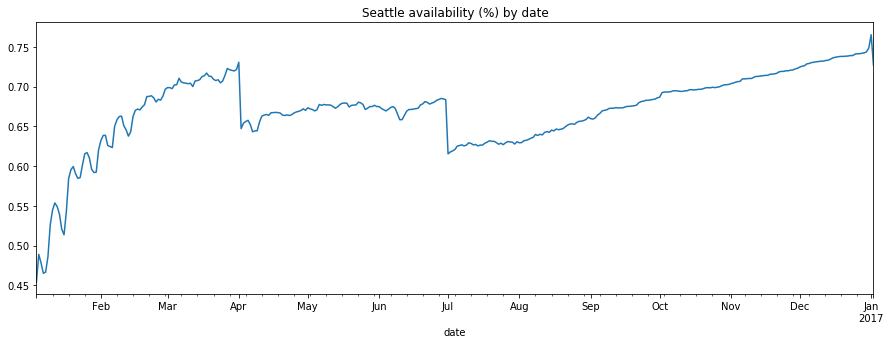

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
calender_df.groupby("date")["available"].mean().plot(ax=ax)
ax.set_title("Seattle availability (%) by date")

For Seattle, availability climbs steadily from Jan - April, then has a sudden dip, then climbs again from April to July, drops again, and then finally climbs until the end of the year and if the same pattern is followed as compared to previous year, it will dip sharply again. 

Text(0.5, 1.0, 'Seattle price (%) by date')

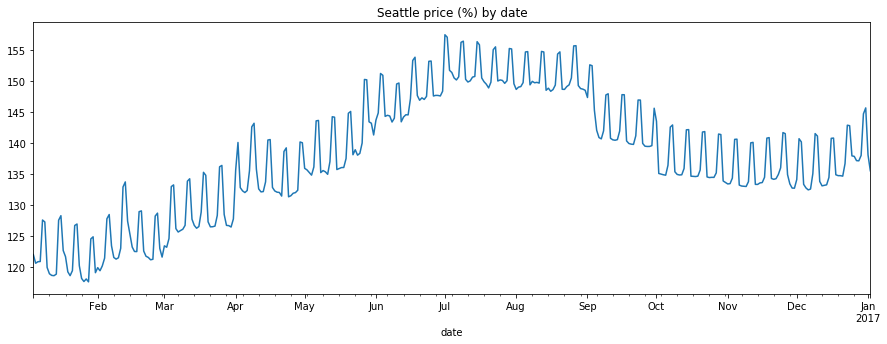

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
calender_df[calender_df["available"]==1].groupby("date")["price"].mean().plot(ax=ax)
ax.set_title("Seattle price (%) by date")

The price has a weekly pattern as well as seasonal pattern. The price increases till july, keeps constant between july and september and drops from January to September.

## Which neighbourhood has the most listings? Which neighborhoods have the highest rating review scores? Which neighborhoods have the highest listing prices?

In [192]:
# filter listinngs which do not have neighbourhood
neighbourhood_listings = listings_trans[listings_trans["neighbourhood"].notnull()]

Text(0.5, 1.0, 'Seattle listings by neighbourhood')

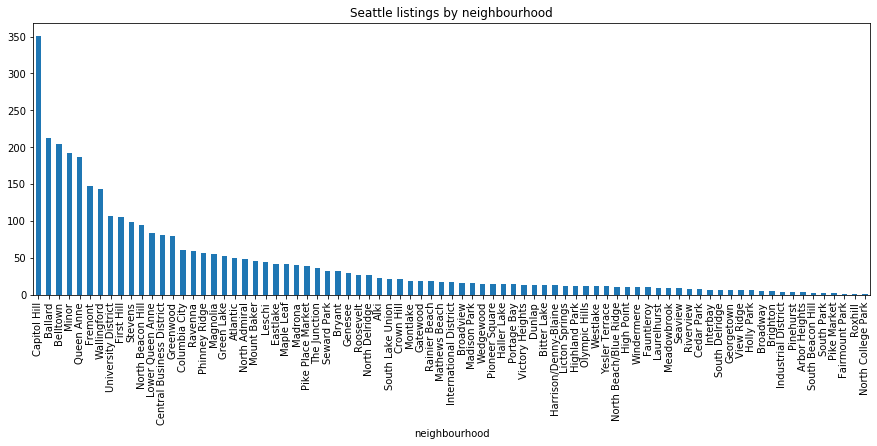

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
neighbourhood_listings.groupby("neighbourhood")["id"].count().sort_values(ascending=False).plot.bar()
ax.set_title("Seattle listings by neighbourhood")

Text(0.5, 1.0, 'Seattle listings by neighbourhood')

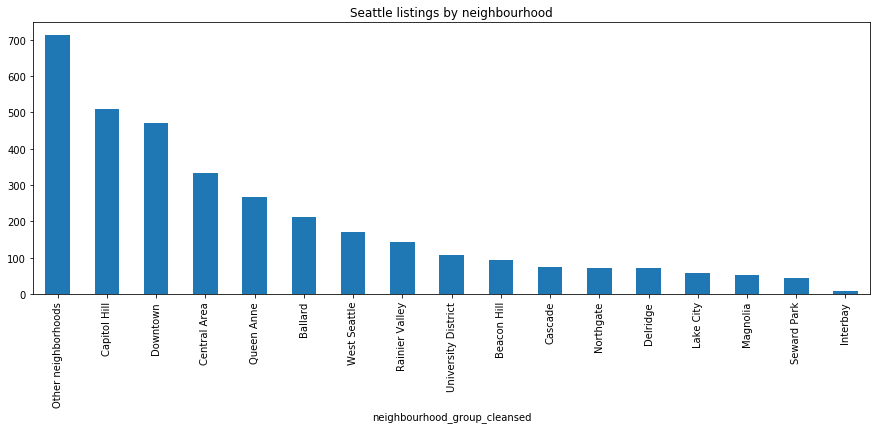

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
neighbourhood_listings.groupby("neighbourhood_group_cleansed")["id"].count().sort_values(ascending=False).plot.bar()
ax.set_title("Seattle listings by neighbourhood")

As we can see from the bar chart, Capitol Hill, the highest, possesses 351 listings and followed by Ballard and Belltown, which possess 213 and 204 listings respectively. We can observe that the Capitol hill and Downtown area has maximum number of listings.

Text(0.5, 1, 'Seattle review scores rating by neighbourhood')

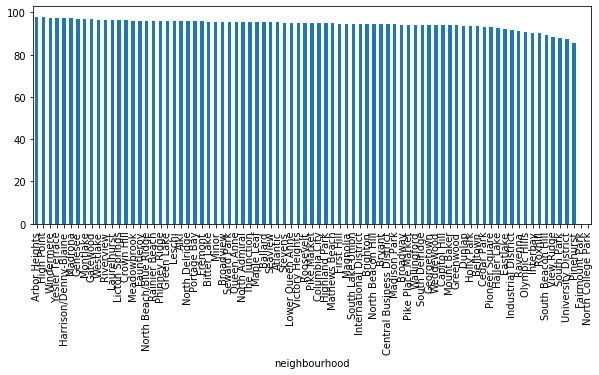

In [195]:
neighbourhood_listings.groupby('neighbourhood')['review_scores_rating'].mean().sort_values(ascending=False).plot.bar(figsize=(10,4))
ax.set_title("Seattle review scores rating by neighbourhood")

/Users/arijitbasu/Desktop/datascience/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1, 'Seattle prices by neighbourhood')

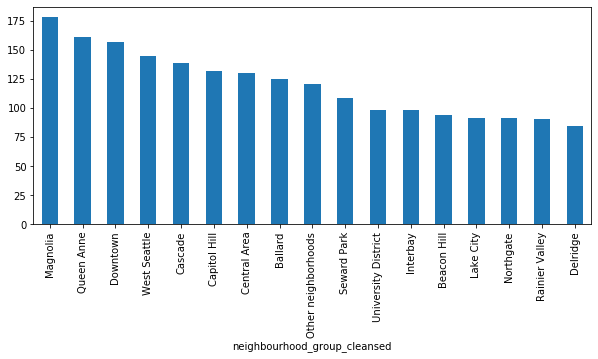

In [196]:
neighbourhood_listings["price"] = \
  neighbourhood_listings["price"].map(lambda x: x.replace("$", "").replace(",", "")).astype("float64")
neighbourhood_listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False).plot.bar(figsize=(10,4))
ax.set_title("Seattle prices by neighbourhood")

Given that a lot of neighbourhood have only one or two listings, we used the cleansed nneighbourhood for computing price listings. Magnolia, Queen Anne, and Downtown have the highest listing prices. Knowing the level of affluency of neighborhoods beforehand would help one to hypothesize which neighborhoods have the highest listing prices.

Also worthy of note, the Downtown neighborhood has a significantly higher number of listings compared to other neighborhoods. 

## MODEL DATA

We will train a linear regrassion model to determine which features affect the prices of listings.

In [197]:
# Convert $ to int
import copy

listings_data = copy.deepcopy(listings_trans)
listings_data["price"] = \
    listings_data["price"].map(lambda x: x.replace("$", "").replace(",", ""))
listings_data["price"] = listings_data["price"].astype("float64")

In [198]:
listings_data["security_deposit"].unique()

array([nan, '$100.00', '$1,000.00', '$700.00', '$150.00', '$500.00',
       '$300.00', '$400.00', '$1,500.00', '$250.00', '$200.00', '$750.00',
       '$140.00', '$350.00', '$600.00', '$95.00', '$5,000.00', '$125.00',
       '$800.00', '$499.00', '$399.00', '$450.00', '$995.00', '$2,500.00',
       '$175.00', '$225.00', '$550.00', '$115.00', '$120.00', '$99.00',
       '$149.00', '$780.00', '$2,000.00', '$1,200.00', '$360.00',
       '$375.00', '$199.00', '$109.00', '$449.00', '$195.00', '$295.00',
       '$185.00', '$134.00', '$650.00', '$180.00', '$1,900.00', '$220.00'],
      dtype=object)

In [199]:
# extra_people
listings_data["extra_people"] = \
    listings_data["extra_people"].map(lambda x: x.replace("$", "").replace(",", ""))
listings_data["extra_people"] = listings_data["extra_people"].astype("float64")

In [200]:
# security_deposit
listings_data["security_deposit"] = \
    listings_data["security_deposit"].map(lambda x: x if isinstance(x, float) else x.replace("$", "").replace(",", ""))
listings_data["security_deposit"] = listings_data["security_deposit"].astype("float64")

In [201]:
# cleaning_fee
listings_data["cleaning_fee"] = \
    listings_data["cleaning_fee"].map(lambda x: x if isinstance(x, float) else x.replace("$", "").replace(",", ""))
listings_data["cleaning_fee"] = listings_data["cleaning_fee"].astype("float64")

In [202]:
listings_data["cleaning_fee"].head()

0      NaN
1     40.0
2    300.0
3      NaN
4    125.0
Name: cleaning_fee, dtype: float64

In [203]:
for column in drop_columns:
    listings_data = listings_data.drop(column, 1)

In [204]:
drop_remaining_columns = ["id", "scrape_id", "listing_url", "last_scraped", "name", "summary", "description",
                         "neighborhood_overview", "notes", "thumbnail_url", "medium_url", "picture_url",
                         "calendar_updated", "host_thumbnail_url", "", "host_picture_url", "host_id",
                         "host_location", "host_about", "host_url", "host_thumbnail_url", "host_picture_url", 
                          "host_name", "xl_picture_url", ""]
exists = ["transit", "thumbnail_url", "medium_url", "xl_picture_url", "space"]
percentage_values = ["host_acceptance_rate", "host_response_rate"]
encoded_values = ["street", "neighbourhood", "neighbourhood_cleansed", "neighbourhood_group_cleansed", "zipcode", 
                  "smart_location", "property_type", "room_type", "bed_type", "cancellation_policy", 
                  "host_neighbourhood", "host_response_time", "host_neighbourhood", "host_response_time"]
boolean_values = ["host_has_profile_pic", "host_identity_verified", "is_location_exact", "instant_bookable", 
                  "require_guest_profile_picture", "require_guest_phone_verification", "host_is_superhost"]

Y = ["monthly_price", "weekly_price", "price"]


date_time = ["first_review", "last_review", "host_since"]

In [207]:
def clean_columns_map(index_arr, map_fn):   
    """
    This function takes in an index array and map function and applies the
    map function to the indexed columns.
    
    @param index_arr: array of integer indices to apply map function to 
    @param map_fn: map function specifying transformation of each value
    @output df: transformed column
    """
    listings_data = listings_data.iloc[:, index_arr]
    for col in index_arr:
        listings_data.loc[:, col] = listings_data.loc[:, col].map(map_fn)
    return listings_data

In [208]:
# timestamp_vars_df = clean_columns_map(date_time, lambda x: pd.Timestamp(x))

for col in boolean_values:
    listings_data[col] = listings_data[col].map(lambda x: x if x == np.nan else x == 't')

In [209]:
enc_listings_data = copy.deepcopy(listings_data)

In [210]:
enc_listings_data = pd.get_dummies(enc_listings_data, columns=encoded_values, drop_first=True, dummy_na=False)

In [211]:
for col in percentage_values:
    enc_listings_data[col] = \
        enc_listings_data[col].map(lambda x: x if isinstance(x, float) else x.replace("%", ""))
    enc_listings_data[col] = enc_listings_data[col].astype("float64")

In [212]:
# Handle exists column
for col in exists:
    enc_listings_data[col] = enc_listings_data[col].map(lambda x: False if x == np.nan else True)

In [213]:
train_data = copy.deepcopy(enc_listings_data)

In [214]:
#drop date time
for col in date_time:
    train_data = train_data.drop(col, 1)

In [215]:
for col in drop_remaining_columns:
    try:
        train_data = train_data.drop(col, 1)
    except KeyError:
        print(col + "already dropped")
        continue

host_thumbnail_urlalready dropped
host_picture_urlalready dropped
already dropped


In [222]:
# train_data["xl_picture_url"].head()
for col in ["monthly_price", "weekly_price"]:
    train_data = train_data.drop(col, 1)

In [230]:
train_data = train_data.dropna(axis=0)
y = train_data[["price"]]
X = train_data.loc[:, ~(train_data.columns=="price")]

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
mod = LinearRegression(normalize=False)
mod.fit(X_train, y_train)

y_train_preds = mod.predict(X_train)
y_test_preds = mod.predict(X_test)


In [240]:
print(r2_score(y_train, y_train_preds))
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_train, y_train_preds))
print(mean_squared_error(y_test, y_test_preds))

1.0
0.9352595228562194
7.116661324797045e-23
939.1253614476822


In [243]:
coefs_df = pd.DataFrame()
coefs_df['var_name'] = X_train.columns
coefs_df['coefs'] = mod.coef_[0, :]
coefs_df['abs_coefs'] = np.abs(mod.coef_[0, :])

pd.set_option('display.float_format', lambda x: '%.3f' % x)
coefs_df.sort_values('abs_coefs', ascending=False).head(10)

,var_name,coefs,abs_coefs
10,accommodates,18.561,18.561
1757,property_type_House,-14.029,14.029
39,Air Conditioning,-12.600,12.600
45,Dog(s),-12.084,12.084
50,Family/Kid Friendly,-11.936,11.936
1716,zipcode_98102,11.649,11.649
4,host_is_superhost,-11.163,11.163
37,reviews_per_month,11.089,11.089
701,"street_Bellevue Ave E, Seattle, WA 98102, Unit...",-10.717,10.717
12,bedrooms,10.680,10.680


For Seattle, the top positive features associated with price are accommodates, reviews_per_month as well as bedrooms. We can see that the zipcode - 98102 is very popular. The top negative features include property_type_House and air conditioning.